# Revisiting Food-Safety Inspections from the Chicago Dataset - A Data Science Tutorial

*Russell Hofvendahl, David Lewis, Jason Trager*

## 0. Foreward¶
Sustainabilist often works on data that is related to quality assurance and control (QA/QC) inspections of public or private infrastructure. Typically, this infrastructure takes the form of solar energy systems or energy efficiency upgrades for buildings. These data sets almost exclusively belong to private entities that have commissioned a study to evaluate how safe and/or well-installed the infrastructure that they financed is. For this reason, it has been very difficult to put anything up in the public sphere about how our work is conducted and any public documentation of what kind of analysis we do.

Enter Epicodus, a coding bootcamp in Portland, OR. Several weeks ago, I met David and Russell - two eager coding students who were just learning how to code. They were attending the first meeting of CleanWeb Portland’s first meeting, which Sustainabilist organized. We were talking about the lack of public datasets in sustainability, and I mentioned how Chicago’s food science data set was very similar to many of the QA/QC data sets that I have looked at. Just like that, a project was born.

The coding work demonstrated herein is 100% that of the student interns, under my guidance for how to structure, examine, and explore the data. The work was conducted using Google Collaboratory, iPython notebooks, and Anaconda’s scientific computing packages.

## 1. Introduction
Foodborne illnesses afflict 48 million Americans each year, resulting in 128,000 hospitalizations and 3,000 deaths [(CDC)](https://www.cdc.gov/foodborneburden/index.html). City governments curb the spread of illness by enforcing stringent health codes but often face daunting inspection schedules and severe budget constraints. To meet regulations both public officials and the businesses they inspect must make difficult decisions in allocating resources.

In this tutorial we present our efforts to support these decision-makers by predicting when and where health code violations will occur. As we draw from past research, clean and explore the data available and ultimately build and test a predictive model of inspection outcomes we invite any questions, comments or critiques that might arise. This project would not be possible without generous community support and we welcome the opportunity to extend that community and expand our skills as developers and data scientists.

### 1.1. Past Work
In the city of Chicago health code violations are rated as minor, serious or critical. Critical violations denote a pressing hazard to public health and an automatic failed inspection, so a health inspector's job is essentially to minimize the duration for which critical violations go undiscovered.

In 2014 the Chicago Department of Public Health (CDPH) began work on a [predictive model of critical violations](https://chicago.github.io/food-inspections-evaluation/) to facilitate this task. The team explored a number of datasets and features before eventually arriving at the following list of predictors:
* inspector assigned
* previous inspection outcomes
* age at inspection
* license for alcohol consumption on premises
* license for over counter tobacco retail
* local temperature at time of inspection
* nearby burglaries
* nearby sanitation complaints
* nearby garbage cart requests.

Using a glmnet model trained on these features the team demonstrated that a data-driven inspections schedule could significantly reduce the time to find a critical violation. This improved inspections schedule has since been adopted by the CDPH and both the [model](https://github.com/Chicago/food-inspections-evaluation) and [data used](https://data.cityofchicago.org/) have been made publicly available.

### 1.2. Premise
In light of the CDPH's success we began this project as an exploration and extension of their work. Whereas the Chicago team set out to predict critical violations we are working to develop a series of models predicting individual violations as well as to explore neural networks for the prediction model.

By developing a higher resolution model we hope to provide actionable information not just to public officials but to restaurants themselves. In addition to a general interest in customers' health restaurants are fined \$500 for each critical and $250 for each serious violation found, and so are strongly motivated to maintain health codes. A real-time violation risk analysis could provide actionable information to restaurants on an ongoing basis, improving inspection outcomes and promoting public health.

### 1.3. Data
Although we are developing a more specific model than the CDPH and using different tools to do so, we both seek to predict inspection outcomes from environmental data. This common investigative question allows us to build on the Chicago team's research, prioritizing the preparation and exploration of those datasets and features already found to be significant. While we may draw from additional sources as work progresses, our current list of datasets used is as follows:
* [food inspections](https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5/data)
* [business licenses](https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr/data)
* [garbage cart requests](https://www.cityofchicago.org/city/en/dataset/garbage_cart_stolenormissing.html)
* [sanitation code complaints](https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Sanitation-Code-Complaints/me59-5fac/data)
* [crimes](https://data.cityofchicago.org/Public-Safety/Crimes-2018/3i3m-jwuy/data)
* [weather](https://darksky.net/dev)

With the exception of weather data from darksky.net, all data is available through the [Chicago Data Portal](https://data.cityofchicago.org/). We will not be working with data on the inspector assigned as this is not publicly available and so not useful in practice.

### 1.4. Tools
We performed initial exploration with Python 3.6 notebooks running on the cloud-based [Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) Jupyter environment. For later work we used local Jupyter notebooks installed with Anaconda and shared through [our Github repository](https://github.com/Sustainabilist/ChicagoDataAnalysis), with Dropbox for large file sharing. We used pip 9 for packages and pandas for data manipulation. We used Slack, Trello and Notable for coordinating work.

## 2. Pre-processing and Data Structuring
In order to derive insights from our data we first had to ensure that each dataset is consistent and ready for further processing (e.g. standardizing column names, removing duplicates, filtering unwanted data, converting types). After this preliminary cleaning we then had to translate certain observations into a form more convenient for analysis (e.g. splitting strings of violations into a series of binary violation columns). Finally we used this data to derive secondary features like the critical violation count or the time since last inspection. The results of these processes are [available on dropbox](https://www.dropbox.com/sh/mtrzy8uy2mduzut/AAB2bWxaOIs5TjMvnygyivHMa?dl=0).

### 2.1. Preparation of Food Inspections Data
To download the inspections data we used Sodapy, a client for the Socrata data platform used by the Chicago Data Portal:

In [12]:
%%capture
!pip install sodapy

In [13]:
import pandas as pd
import numpy as np
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# First 50000 results, recieved as JSON & returned as dict
# Columns converted to snake case, special chars removed,
# dates and location formatted
results = client.get("4ijn-s7e5", limit=50000)

# Convert to pandas DataFrame
inspections = pd.DataFrame.from_records(results)

# Add explanation for parameters for client.get method (RH: resolved? 7/12)
# DL resolved 7/13

We determined the dataset identifer **"4ijn-s7e5"** for the client.get() method based upon the URL https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5/data


Conveniently,  Sodapy converts all columns to snake case, removes special characters and standardizes date format by default. As Socrata restricts queries to 50,000 entries we then paged through the remainder to access the full dataset: 

In [14]:
# Download remaining food inspections (limit 50000 / call)
start = 50000
while results:
    results = client.get("4ijn-s7e5", limit=50000, offset=start)
    inspections = inspections.append(pd.DataFrame.from_records(results))
    start += 50000

After exploring the data and reading through the CDPH's work in R we then applied a series of filters to produce a consistent and usable dataset:

In [15]:
# Remove trailing backslash (left over from sodapy conversion of "License #" column)
inspections.rename(columns={"license_": "license"}, inplace=True)

# Drop rows with missing data
inspections.dropna(subset=["inspection_date", "license", "latitude", "longitude"], inplace=True)

# Drop duplicates
inspections.drop_duplicates("inspection_id", inplace=True)

# Drop "0" licenses
inspections = inspections[inspections.license != "0"]

# Only consider successful inspections
inspections = inspections[~inspections.results.isin(["Out of Business", "Business Not Located", "No Entry"])]

For later calculations we converted location data to floats:
# Duplicate code for coverting lat long to floats (rh: resolved? 7/12)
# DL g2g

In [16]:
# Convert latitude & longitude to floats
inspections.latitude = inspections.latitude.astype(float)
inspections.longitude = inspections.longitude.astype(float)

Depending on risk level all facilities are subject to canvass inspections at an interval of six months to two years. In addition to canvass-type inspections, a facility may also be inspected to establish an initial license, to correct a recent violation or due to public complaints. To ensure that our data is representative of restaurants operating as usual we filtered the dataset to consist only of canvass inspections:

# What is canvas? canvas vs Canvass? Explain (rh 7/12: resolved?)

# DL g2g

In [17]:
# Only consider canvass inspections (not complaints or re-inspections)
inspections = inspections[inspections.inspection_type == "Canvass"]

We also filtered inspections by facility type, to eliminate the inconsistency of data from sources like hospitals or schools which follow different inspection schedules:

In [18]:
# Only consider restaurants and grocery stores (subject to change)
inspections = inspections[inspections.facility_type.isin(["Restaurant", "Grocery Store"])]

Finally we saved the resulting dataframe as a CSV file, ready for later use:

In [19]:
import os.path
root_path = os.path.dirname(os.getcwd())

# Save result
inspections.to_csv(os.path.join(root_path, "DATA/food_inspections_demo.csv"), index=False)

### 2.2. Preparation of Remaining Socrata Data
The process of downloading and filtering business licenses, garbage cart requests, sanitation complaints and crimes was much the same as with food inspections - for specifics see the [CODE folder of our project repository](https://github.com/Sustainabilist/ChicagoDataAnalysis/tree/master/CODE). 

In brief:
* All datasets were formatted by sodapy and filtered to remove duplicates and missing data.
* Crimes were filtered to include only burglaries since 2010 to reduce size and ensure consistency.
* Garbage cart requests and sanitation complaints were filtered to include only completed or open requests.

### 2.3. Preparation of Weather Data
The process of pulling the weather data from the [Darksky API](https://darksky.net/dev) was straightforward and can be found in notebook 16 in the [CODE folder](https://github.com/Sustainabilist/ChicagoDataAnalysis/tree/master/CODE)  of our project repository. To eliminate redundant API calls, the script first imports any existing weather data and checks for records in this data first before requesting from the API.

Each weather record consists of an inspection ID, a date, the pricipitation intensity, the maxiumum temperature, the windspeed and the humidity at that date. As the Chicago region only measures some twenty miles across we used a single location in central Chicago for all weather records.

### 2.4. Calculation of Violations Data
Each entry in the violations column of the food inspections dataset is made up of a number of violation/comment pairs joined into a string:

In [20]:
inspections.iloc[0].violations[:500]

'1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES | 2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: OBSERVED NO EMPLOYEE HEALTH POLICY ON SITE. INSTRUCTED MUST PROVIDE. PRIORITY FOUNDATION VIOLATION 7-38-012(A). NO CITATION ISSUED. | 4. PROPER USE OF RESTRICTION AND EXCLUSION | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: OBSERV'

Although this is a rich source of data, the format makes it difficult to perform operations based on specific violations (e.g. charting the distribution of critical violations).

To make violations data more accessible for analysis we split each entry into a series of columns representing the presence of each violation with a binary value:

In [28]:
# Split violations into binary values for each violation
def split_violations(violations):
    values_row = pd.Series([])
    if type(violations) == str:
        violations = violations.split(' | ')
        for violation in violations:
            index = "v_" + violation.split('.')[0]
            values_row[index] = 1
    return values_row

# Calculate violation values (5 mins), set missing violations to 0
values_data = inspections.violations.apply(split_violations).fillna(0)

# Generate column names
critical_columns = [("v_" + str(num)) for num in range(1, 15)]
serious_columns = [("v_" + str(num)) for num in range(15, 30)]
minor_columns = [("v_" + str(num)) for num in range(30, 45)]
minor_columns.append("v_70")

# Create complete list of column names
columns = critical_columns + serious_columns + minor_columns

# Create dataframe using column names, violation data and inspection ID
values = pd.DataFrame(values_data, columns=columns)
values['inspection_id'] = inspections.inspection_id

# Display resulting dataframe
values.iloc[10:17]

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,...,v_37,v_38,v_39,v_40,v_41,v_42,v_43,v_44,v_70,inspection_id
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182136
191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182138
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2182126
208,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182114
219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182101
222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2182090
228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182083
244,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2182066
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182041
273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2182028


In [38]:
# Display selection of values dataframe
values.iloc[10:17]

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,...,v_37,v_38,v_39,v_40,v_41,v_42,v_43,v_44,v_70,inspection_id
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182136
191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182138
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2182126
208,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182114
219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182101
222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2182090
228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182083


# Blurb about critical, serious, and minor violations. No visual to represent the following outcome of the code columns. Add a visual/description
# Resolved DL  7/13

While not especially human-readable, this format allows us to easily access specific violation data, sum sets of violations and train models that require numeric or binary features.

Next we created a separate dataframe for critical, serious and minor violation counts by pairing each inspection ID with the sum of the appropriate subset of violation values:

In [29]:
# Count violations
counts = pd.DataFrame({
    "critical_count": values[critical_columns].sum(axis=1),
    "serious_count": values[serious_columns].sum(axis=1),
    "minor_count": values[minor_columns].sum(axis=1)
})

counts['inspection_id'] = inspections.inspection_id

# Display selection of sums dataframe
counts.iloc[10:17]

,critical_count,serious_count,minor_count,inspection_id
190,0.0,1.0,1.0,2182136
191,1.0,0.0,1.0,2182138
199,0.0,0.0,9.0,2182126
208,2.0,0.0,3.0,2182114
219,1.0,0.0,4.0,2182101
222,0.0,3.0,5.0,2182090
228,0.0,0.0,3.0,2182083


Lastly, we saved both datasets for later use:

In [39]:
# Save violation values and counts
values.to_csv(os.path.join(root_path, "DATA/violation_values_demo.csv"), index=False)
counts.to_csv(os.path.join(root_path, "DATA/violation_counts_demo.csv"), index=False)

## 3. Exploratory Analysis
To familiarize ourselves with the data and to inform feature selection and model design we then took some time to explore and visualize **the information**. During this period we investigated the spatial distribution of inspections, the comments accompanying violations, the relative distribution of violations and the role of past inspection outcomes as predictors. We also looked at facility inspection statistics to assess the economic potential of violation forecasting.

### 3.1. Inspections Map
To improve our understanading of the inspections dataset and its relation to other location-based data we used folium to generate an inspections heat map:

In [40]:
%%capture
!pip install folium

In [41]:
# Import necessary packages 
from folium import folium, plugins
from IPython.display import HTML

%matplotlib inline

In [42]:
# Generate map
m = folium.Map([41.8600, -87.6298], zoom_start=10)

# Convert to (n, 2) nd-array format for heatmap
inspections_arr = inspections.sample(20000)[["latitude", "longitude"]].values

# Plot heatmap
m.add_child(plugins.HeatMap(inspections_arr.tolist(), radius=10))

# Keep both b/c seeing the plots of inspections adds more insight. It also provides another opprotunity for the heatmap to render in various view formats

# Test to make sure it does in HTML

#### Images of plotted inspections heatmap 

<img src="../MAPS/inspection_heat_map_screenshots/heat_map_resize_1.png" width="800" />
<img src="../MAPS/inspection_heat_map_screenshots/heat_map_resize_2.png" width="800" />
<img src="../MAPS/inspection_heat_map_screenshots/heat_map_resize_3.png" width="800" />

### 3.2. Comments Wordcloud
Wordclouds are an easy and surprisingly insightful means to explore text data, so to explore the feedback that facilities recieve alongside violations we concatenated all comments and used the resulting string to generate a wordcloud:

In [44]:
%%capture
!pip install wordcloud

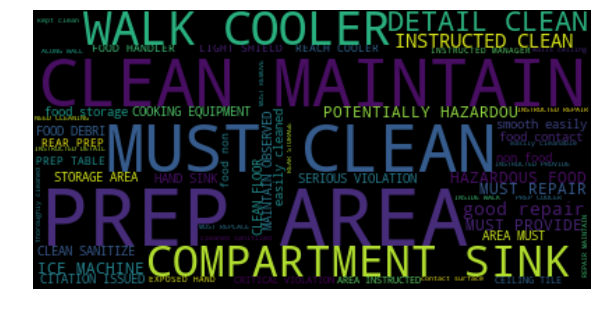

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract comments from violations
def get_comments(violations):
    comments = ""
    if type(violations) == str:
        violations = violations.split(' | ')
        for violation in violations:
            violation = violation.split('Comments:')
            if len(violation) == 2:
                comments += violation[1]
    return comments

# Concatenate all comments
comments = inspections.violations.apply(get_comments).str.cat(sep=" ")

# Generate wordcloud
comments_wordcloud = WordCloud().generate(comments)

# Plot wordcloud
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(comments_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Although qualitative, the results point to maintenance, cleanliness, prep areas, sinks and coolers as common areas of concern.

### 3.4. Violations Chart
For a more quantitative perspective we used the violations data and [a chart of the Chicago health code](https://webapps1.cityofchicago.org/healthinspection/Code_Violations.jsp) to generate a simple bar graph:

The violation_titles.csv file is created in the  21_calculate_violation_data.ipynb file within the [CODE folder](https://github.com/Sustainabilist/ChicagoDataAnalysis/tree/master/CODE).

# More information about how this chart is created, how was each color properly assigned to each bar (assuming bc they are all in order order to begin with, which is really smart, call that out and as part of the data cleaning)? Refer back to the violation_titles.csv file, maybe show a visual of that dataset

# Also the violation_titles.csv file is not currently availble to users who want to run this code, add it to the data folder and instruct users on how to clone and and open this publication locally, can put instructions in README

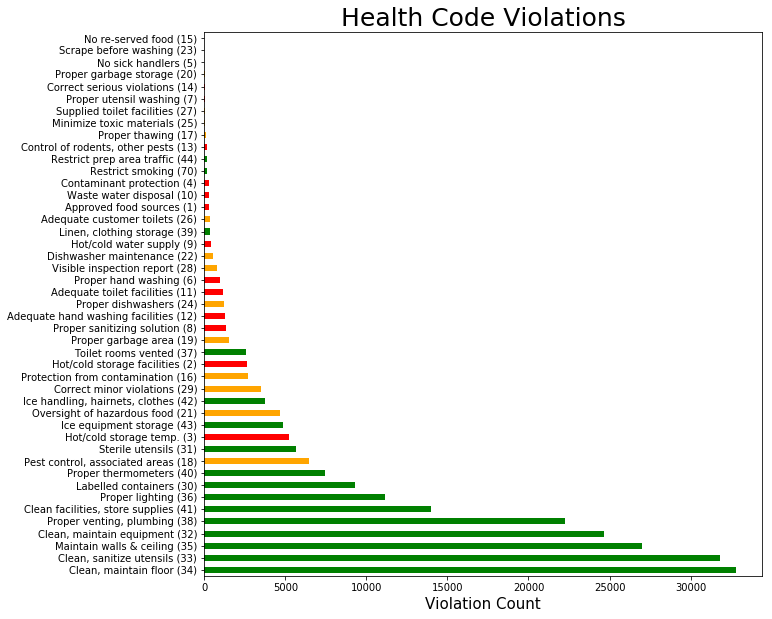

In [47]:
# Import violation titles, title values dataframe
titles = pd.read_csv(os.path.join(root_path, "DATA/violation_titles.csv"))
titled_values = values.rename(columns=titles.iloc[0])

# Sum binary values for each violation
sums = titled_values.drop("inspection_id", axis=1).sum()

# Generate color list
colors = ["red"] * 15 + ["orange"] * 14 + ["green"] * 16

# Sort sums and colors by sum value
sum_data = pd.DataFrame({"sums": sums, "colors": colors}).sort_values("sums")

# Plot bar chart
plt.rcParams['figure.figsize'] = (10, 10)
ax = sum_data.sums.plot(kind="barh", color=sum_data.colors)
ax.set_title("Health Code Violations", fontsize=25)
ax.set_xlabel("Violation Count", fontsize=15)
ax.invert_yaxis()
plt.show()

As this chart makes clear, the vast majority of violations are minor (30+), with only a scattering of serious (15-29) and critical (1-14) violations.

The most common violations pertain to cleanliness and maintenance of floors, walls and ceilings; sanitation and maintenance of utensils and equipment; proper venting; and proper organization of food and cleaning supplies.

The most common serious violation is improper control of vermin (18), and the most common critical violations relate to improper storage of hot and cold foods (2, 3).

### 3.5. Inspection History
The Chicago team found one of the greatest predictors of critical violations and failed inspections to be the establishment's recent inspection history. To validate this we grouped inspections by license, shifted each group to find the previous inspection and set up a table to compare conditional likelihoods:

# Work on explaining this code a bit more, step by step, maybe would be good to show a quick visual of the inspections dataset. Also the final table could use some editing, is hard to determine what is a previous result

In [135]:
# Sort inspections by date
df = inspections.sort_values(by="inspection_date")

# Only consider inspections with clear results
df = df.loc[df.results.isin(["Pass", "Fail"])]

# Group inspections by license and shift 1 to find previous results
df["previous_results"] = df.groupby(by="license").shift().results

# Calculate cross tabulation of results and previous results
chart = pd.crosstab(df.previous_results, df.results)

# Make Numpy array from total counts of prior fails and passes with the 
# following(post) results
chart_arr = np.array(chart)

# Create new dataframe to clearly dispay prior and post results
pass_fail_chart = pd.DataFrame({"Prior Fail":chart_arr[:,0], 
                                "Prior Pass":chart_arr[:,1]})
pass_fail_chart.index = pass_fail_chart.index.rename("")
pass_fail_chart.rename(index={0:"Post Fail",1:"Post Pass"})

,Prior Fail,Prior Pass
,,
Post Fail,2817,4843
Post Pass,5549,20642


In [20]:
# P(fail | previous fail)
chart.loc["Fail", "Fail"] / chart.loc["Fail", :].sum()

0.3677545691906005

In [21]:
# P(fail | previous pass)
chart.loc["Pass", "Fail"] / chart.loc["Pass", :].sum()

0.21186667175747395

# Twice as likely? Is this 21% who passed then failed vs 37% of who failed then faild again? Not a huge deal but maybe we can describe this result a bit better bc it is IMPORTANT!

We found that facilities with a previous failure were almost twice as likely to fail as those with previous passing inspections, supporting the findings of the Chicago team.

### 3.6. Economic Impact
Before investing time in a violations forecasting tool we first set out to assess whether such information would actually be valuable. If businesses rarely fail inspections and generally do so in summer, for example, even perfect information would not provide much additional value.

To explore this we first created a temporary dataframe from the relevant data:

# Visual some of these steps, help to explain what the new merged dataset looks like. At the end do temp.head() or something

In [22]:
# Create temporary dataframe
temp = pd.merge(inspections, values, on="inspection_id")

# Convert inspection_date to datetime format
temp["datetime"] = pd.to_datetime(temp["inspection_date"])

# Calculate fines
temp["fines"] = temp[critical_columns].sum(axis=1) * 500
temp["fines"] += temp[serious_columns].sum(axis=1) * 250

# Count critical violations
temp["criticals"] = temp[critical_columns].sum(axis=1)

We then grouped inspections by license (a code shared by all inspections for a business) and for each group determined the age, yearly fails and other statistics:

In [23]:
import math

# Sort by date
temp.sort_values("datetime", inplace=True)

# Calculate statistics for license groups
def get_stats(group):
    days = (group.iloc[-1].datetime - group.iloc[0].datetime).days + 1
    years = days / 365.25  
    inspections = len(group)
    yearly_inspections = inspections / math.ceil(years)
    fails = len(group[group.results == "Fail"])
    yearly_fails = fails / math.ceil(years)
    fines = group.fines.sum()
    yearly_fines = fines / math.ceil(years)
    criticals = group.criticals.sum()
    yearly_criticals = criticals / math.ceil(years)
    return pd.Series({
        "years": years,
        "inspections": inspections,
        "yearly_inspections": yearly_inspections,
        "fails": fails,
        "yearly_fails": yearly_fails,
        "fines": fines,
        "yearly_fines": yearly_fines,
        "criticals": criticals,
        "yearly_criticals": yearly_criticals
    })

# Group by license and apply get_stats
businesses = temp.groupby('license').apply(get_stats).reset_index()

To assess whether businesses fail enough inspections for risk analysis to be worthwhile we plotted a pareto chart describing the number of businesses in each yearly fails bracket:

# Maybe more explanation about how you made this chart, i.e. the fancy blue line

# Create this as Russell's awesome pareto chart funtion then resuse it to do the yearly critical violations pareto chart, DRY AF

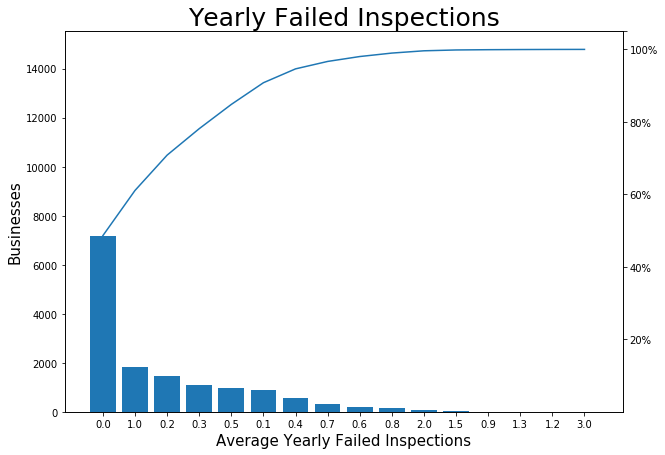

In [27]:
# Define function to plot pareto chart
def plot_pareto(series, title, xlabel, ylabel):
    index = np.arange(len(series))
    fig, ax1 = plt.subplots()
    ax1.bar(index, series)
    ax1.plot(index, series.cumsum())
    ax1.set_xticks(index)
    ax1.set_xticklabels(series.index)
    ax1.set_title(title, fontsize=25)
    ax1.set_xlabel(xlabel, fontsize=15)
    ax1.set_ylabel(ylabel, fontsize=15)
    ax2 = ax1.twinx()
    ax2.set_yticks([1, 2, 3, 4, 5, 5.25])
    ax2.set_yticklabels(["%d%%"%(x*20) for x in range(1,6)])
    plt.show()

# Count restaurants in each rounded yearly fails bracket
yearly_fail_counts = businesses.yearly_fails.round(1).value_counts()
                   
# Plot pareto chart
plt.rcParams['figure.figsize'] = (10, 7)
plot_pareto(
    yearly_fail_counts,
    "Yearly Failed Inspections",
    "Average Yearly Failed Inspections",
    "Businesses"
)

In [28]:
# Fraction of businesses failing .5 or more inspections yearly
len(businesses.loc[businesses.yearly_fails >= .5]) / len(businesses)

0.24533152909336942

In [29]:
# Fraction of businesses failing 1 or more inspections yearly
len(businesses.loc[businesses.yearly_fails >= 1]) / len(businesses)

0.13403247631935047

We found that 24% of businesses fail over .5 inspections in a year, with 13% failing 1 or more inspections yearly.

We then plotted a similar pareto chart to explore the number of businesses in each bracket of yearly critical violations:

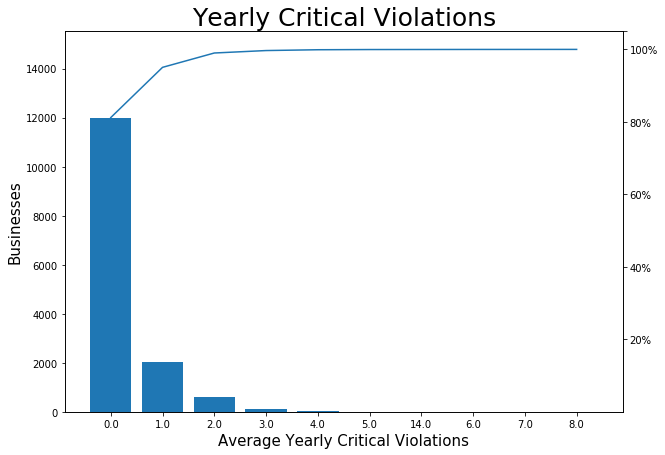

In [30]:
# Count restaurants in each rounded yearly fails bracket
yearly_critical_counts = businesses.yearly_criticals.round().value_counts()

# Plot pareto chart
plot_pareto(
    yearly_critical_counts,
    "Yearly Critical Violations",
    "Average Yearly Critical Violations",
    "Businesses"
)

As this plot shows, roughly 20% of businesses experience one or more critical violations each year.

To explore how much these businesses pay in fines we plotted a histogram of fines paid yearly (\$500 per critical violation, $250 per serious violation):

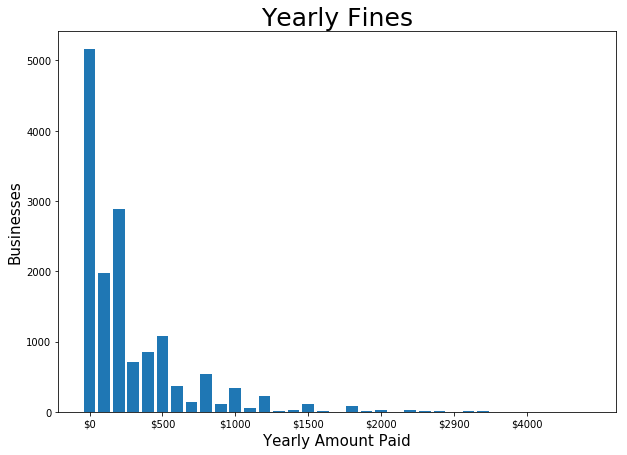

In [31]:
# Count restaurants in each yearly fines bracket
fine_counts = businesses.yearly_fines.round(-2).value_counts().sort_index()

index = np.arange(len(fine_counts))

fig, ax = plt.subplots()
ax.bar(index, fine_counts)
ax.set_xticks(index[::5])
ax.set_xticklabels(["$%d"%x for x in fine_counts.index[::5]])
ax.set_title("Yearly Fines", fontsize=25)
ax.set_xlabel("Yearly Amount Paid", fontsize=15)
ax.set_ylabel("Businesses", fontsize=15)

plt.show()

In [32]:
# Fraction of businesses paying $500 or more yearly
len(businesses.loc[businesses.yearly_fines >= 500]) / len(businesses)

0.21163734776725304

In [33]:
# Fraction of businesses paying $250 or more yearly
len(businesses.loc[businesses.yearly_fines >= 250]) / len(businesses)

0.43606224627875506

We found that 21% of businesses pay \$500 or more per year in fines and 43% pay $250 or more.

Finally we plotted the percentage of all fines paid for each month, to see if violations could be easily predicted as a function of seasonal temperature:

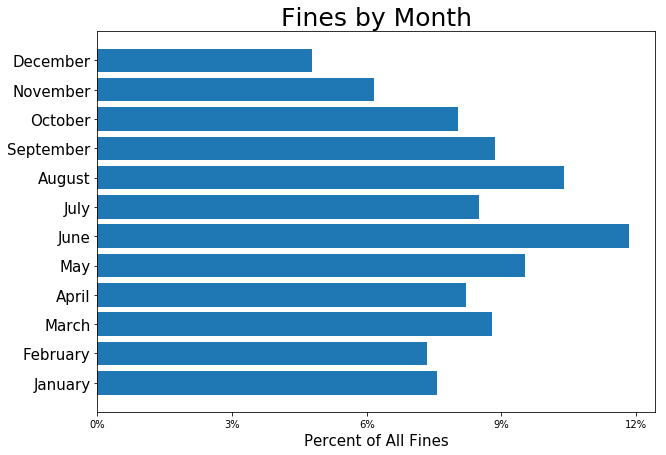

In [34]:
# Calculate total fines paid for each month
temp["month"] = temp.datetime.apply(lambda x: x.month)
month_fines = temp.groupby("month").fines.sum() / temp.fines.sum()

# List months
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Plot bar chart
fig, ax = plt.subplots()
index = np.arange(len(month_fines))
ax.barh(index, month_fines)
ax.set_yticks(index)
ax.set_yticklabels(months, fontsize=15)
ax.set_xticks([x*3/100 for x in range(5)])
ax.set_xticklabels(["%d%%"%(x*3) for x in range(5)])
ax.set_title("Fines by Month", fontsize=25)
ax.set_xlabel("Percent of All Fines", fontsize=15)


plt.show()

# Work on making a stronger conclusion, succinctly close with a sentance on goal of next steps 

Violation fines clearly show strong seasonal variation, with more than twice as much paid in June as in December.

In summary there is mixed evidence for the information value of violation prediction. Businesses do pay significant fines but do not face frequent inspection failures and a forecast would have to perform significantly better than using seasons as a heuristic to be worthwhile. However, a high resolution risk analysis could still be valuable to businesses pursuing performance even outside of inspections, and even one serious violation averted could would save a business \$250.

## 5. Next Steps
With preliminary cleaning and exploration complete, our next task will be to select and calculate a set of features (e.g. time since last inspection or previous critical violations). We will then derive a table relating these features to inspection outcomes (violations).

We could then move on to selecting a neural net type appropriate to the data, training the model and performing a stastical analysis of the results and, finally, sharing our findings. Depending these outcomes we might then take on the forecasting tool as a separate project.

## About the Authors
* David Lewis is a seasoned corporate responsibility professional working to utilize technology to help improve the health and well being of human populations through environmental stewardship. 
* Russell Hofvendahl is a web application developer with a deep-seated love of data-driven decision making. Russell is excited to explore the applications of data science and machine learning in reducing bias and improving judgement.
* Jason S. Trager, Ph.D. is the managing partner at Sustainabilist and an expert in process improvement for distributed systems.  Jason’s work portfolio includes the creation of novel data-driven methods for improving contractor performance, machine learning to optimize value in energy efficiency sales, and equipment maintenance optimization methodologies. 